# DBSCAN method of clustering for Online Retail Dataset

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular unsupervised clustering algorithm. It groups points that are closely packed together while marking points that are in low-density regions as outliers. 

There are 2 main parameters that the algorithm requires to perform clustering:
1.	Epsilon (ε): The maximum distance between two points for them to be considered as neighbors.
2.	MinPts: The minimum number of points required to form a dense region (a cluster).


Advantages
-	Can find arbitrarily shaped clusters: Unlike k-means, which assumes spherical clusters, DBSCAN can find clusters of any shape.
-	No need to specify the number of clusters: Unlike k-means, where you need to specify the number of clusters beforehand, DBSCAN only requires ε and MinPts.
-   Not sensitive to noise as it accounts for noise during labelling.

Disadvantages
-	Sensitive to parameter selection: The results can be highly sensitive to the choice of ε and MinPts.
-	Not suitable for varying densities: DBSCAN struggles with data that has clusters with varying densities, as it uses the same ε and MinPts for all clusters.


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score
import itertools
import plotly.graph_objects as go

In [23]:
df = pd.read_csv("PCA_Customer_Data.csv")
df.head()

,CustomerID,PC1,PC2,PC3,PC4,PC5,PC6
0,12346.0,-2.659371,-1.636472,-0.543115,-0.054209,-0.114366,-1.988442
1,12347.0,3.780832,-1.479966,0.605603,-0.345088,-0.010899,0.721764
2,12350.0,-1.819527,-0.541717,0.965524,-1.310723,-0.606334,0.227094
3,12352.0,0.232564,-1.475126,-0.938797,-0.539464,-0.220370,0.484831
4,12353.0,-2.318130,0.519302,-0.257238,-1.407346,-0.810911,0.718952


In [24]:
df.drop(columns=['CustomerID'], inplace=True)
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-2.659371,-1.636472,-0.543115,-0.054209,-0.114366,-1.988442
1,3.780832,-1.479966,0.605603,-0.345088,-0.010899,0.721764
2,-1.819527,-0.541717,0.965524,-1.310723,-0.606334,0.227094
3,0.232564,-1.475126,-0.938797,-0.539464,-0.220370,0.484831
4,-2.318130,0.519302,-0.257238,-1.407346,-0.810911,0.718952


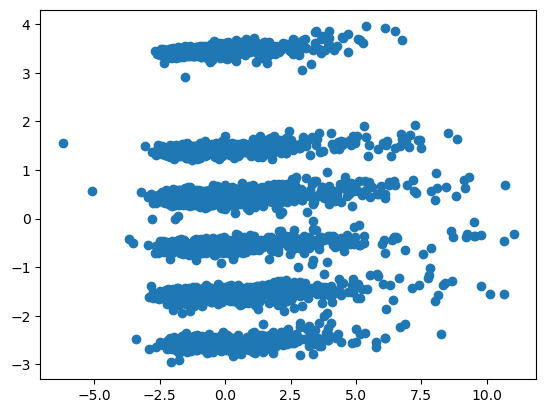

In [64]:
plt.scatter(df['PC1'], df['PC2'])

In [27]:
epsilon = np.linspace(0.01, 1, 20)
min_samples = np.arange(2, 25, 2)

combinations = list(itertools.product(epsilon, min_samples))
N = len(combinations)
N

240

In [62]:
def Gridsearch(combinations, X):
    scores = []
    all_label = []

    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples, 
                              metric='mahalanobis', metric_params={'VI':np.cov(X)}, 
                              algorithm='brute', leaf_size=30, n_jobs=-1).fit(X)
        labels = dbscan_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)

        # discounts the presence of noise as a considered cluster
        if -1 in labels_set:
            num_clusters -= 1

        if (num_clusters < 2) or (num_clusters > 25):
            scores.append(-20)
            all_label.append("Poor")
            print(" at iteration : ",i ,"ep = ", eps, "min_samples = ", num_samples, "clusters = ", num_clusters, "moving on... ")
            continue

        scores.append(silhouette_score(X, labels))
        all_label.append(labels)
        print(" at iteration : ",i ,"ep = ", eps, "min_samples = ", num_samples, "clusters = ", num_clusters)
    
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_label[best_index]
    best_score = scores[best_index]

    return {
        'best epsilon' : best_parameters[0],
        'best_min_samples': best_parameters[1],
        'best_labels': best_labels,
        'best_score': best_score
    }

In [63]:
best_params = Gridsearch(combinations, df)

 at iteration :  0 ep =  0.01 min_samples =  2 clusters =  49 moving on... 
 at iteration :  1 ep =  0.01 min_samples =  4 clusters =  0 moving on... 
 at iteration :  2 ep =  0.01 min_samples =  6 clusters =  0 moving on... 
 at iteration :  3 ep =  0.01 min_samples =  8 clusters =  0 moving on... 
 at iteration :  4 ep =  0.01 min_samples =  10 clusters =  0 moving on... 
 at iteration :  5 ep =  0.01 min_samples =  12 clusters =  0 moving on... 
 at iteration :  6 ep =  0.01 min_samples =  14 clusters =  0 moving on... 
 at iteration :  7 ep =  0.01 min_samples =  16 clusters =  0 moving on... 
 at iteration :  8 ep =  0.01 min_samples =  18 clusters =  0 moving on... 
 at iteration :  9 ep =  0.01 min_samples =  20 clusters =  0 moving on... 
 at iteration :  10 ep =  0.01 min_samples =  22 clusters =  0 moving on... 
 at iteration :  11 ep =  0.01 min_samples =  24 clusters =  0 moving on... 
 at iteration :  12 ep =  0.06210526315789474 min_samples =  2 clusters =  332 moving on.

In [66]:
print(best_params)

{'best epsilon': 0.4789473684210527, 'best_min_samples': 2, 'best_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 'best_score': 0.5419054908925082}


In [67]:
df['cluster'] = best_params['best_labels']

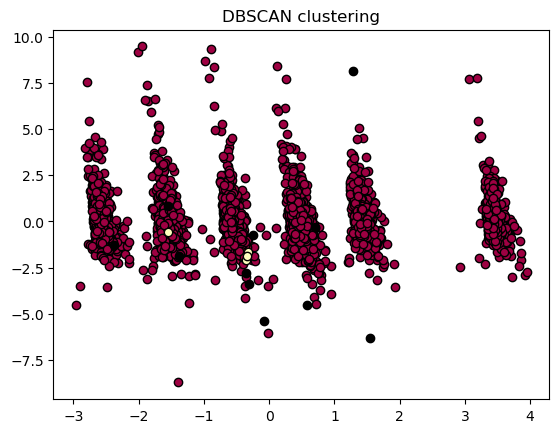

In [69]:
# Plot results
unique_labels = set(df['cluster'])
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black is used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (df['cluster'] == k)

    xy = df[class_member_mask].values
    plt.plot(xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustering')
plt.show()

In [70]:
print(unique_labels)

{0, 1, -1}


In [73]:
colors = ['#e8000b', '#1ac938', '#023eff',
        #    '#555555', '#00fff0'
           ]

# Create separate data frames for each cluster
cluster_0 = df[df['cluster'] == 0]
cluster_1 = df[df['cluster'] == 1]
cluster_2 = df[df['cluster'] == 2]
# cluster_3 = df[df['cluster'] == 3]
# cluster_4 = df[df['cluster'] == 4]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
# fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], 
#                            mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))
# fig.add_trace(go.Scatter3d(x=cluster_4['PC1'], y=cluster_4['PC2'], z=cluster_4['PC3'], 
#                            mode='markers', marker=dict(color=colors[4], size=5, opacity=0.4), name='Cluster 4'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()